In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import joblib
import os

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
# --- Step 1: Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# Define file paths in Google Drive
file_path = '/content/drive/My Drive/customer_churn_telecom_services.csv'
output_dir = '/content/drive/My Drive/Churn_Analysis_Outputs/'
os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- Step 2: Load the Data ---
df = pd.read_csv(file_path)

In [ ]:
# Display basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\nFirst 5 Rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-n

In [ ]:
# --- Step 3: Data Preprocessing ---
# Explanation: Clean and prepare the data for analysis.

# Handle Missing or Invalid Values
# Explanation: The 'TotalCharges' column may contain empty strings or non-numeric values.
# Convert to numeric, replacing invalid entries with NaN, and fill with median.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print("\nMissing Values Before Imputation:")
print(df.isnull().sum())
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


Missing Values Before Imputation:
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


<ipython-input-7-b5a04cfb0b36>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [ ]:
# Encode Categorical Variables
# Explanation: Convert categorical variables to numerical using LabelEncoder.
# Save the encoder for 'Churn' to decode predictions later.
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                    'PaperlessBilling', 'PaymentMethod', 'Churn']
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Save the LabelEncoder for 'Churn'
joblib.dump(le, os.path.join(output_dir, 'churn_label_encoder.pkl'))

['/content/drive/My Drive/Churn_Analysis_Outputs/churn_label_encoder.pkl']

In [ ]:
# Feature Engineering
# Explanation: Create new features to capture patterns, such as tenure groups and total services.
df['TenureGroup'] = pd.cut(df['tenure'], bins=[0, 12, 24, 36, 48, 60, 72],
                           labels=['0-12', '13-24', '25-36', '37-48', '49-60', '61-72'])
df['TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                           'OnlineBackup', 'DeviceProtection', 'TechSupport',
                           'StreamingTV', 'StreamingMovies']] > 0).sum(axis=1)

In [ ]:
# Save Cleaned Data
# Explanation: Save the preprocessed dataset to Google Drive for use in Power BI.
cleaned_data_path = os.path.join(output_dir, 'cleaned_customer_churn.csv')
df.to_csv(cleaned_data_path, index=False)
print(f"\nCleaned dataset saved to '{cleaned_data_path}'")


Cleaned dataset saved to '/content/drive/My Drive/Churn_Analysis_Outputs/cleaned_customer_churn.csv'


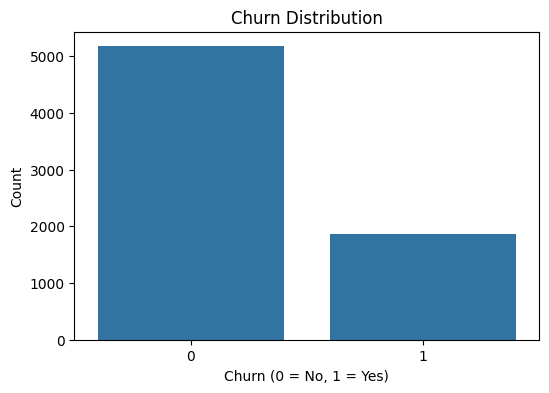

In [ ]:
# Exploratory Data Analysis (EDA)
# Explanation: Perform EDA to uncover patterns and relationships. Save visualizations to Google Drive.

# Churn Distribution
# Explanation: Visualize the proportion of churned vs. non-churned customers.
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.savefig(os.path.join(output_dir, 'churn_distribution.png'))
plt.show()

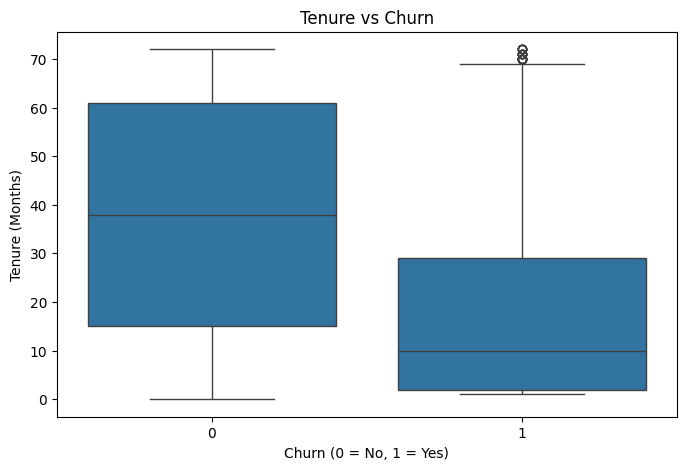

In [ ]:
# Tenure vs. Churn
# Explanation: Compare tenure distributions for churned and non-churned customers.
plt.figure(figsize=(8, 5))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Tenure vs Churn')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Tenure (Months)')
plt.savefig(os.path.join(output_dir, 'tenure_vs_churn.png'))
plt.show()

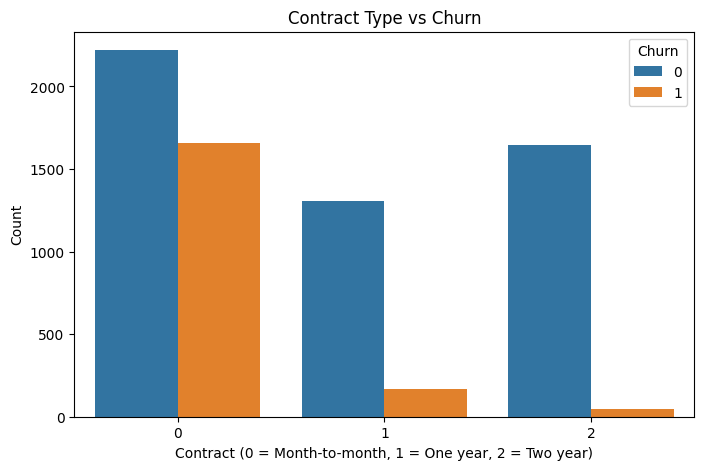

In [ ]:
# Contract Type vs. Churn
# Explanation: Analyze how contract type affects churn.
plt.figure(figsize=(8, 5))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Contract Type vs Churn')
plt.xlabel('Contract (0 = Month-to-month, 1 = One year, 2 = Two year)')
plt.ylabel('Count')
plt.savefig(os.path.join(output_dir, 'contract_vs_churn.png'))
plt.show()

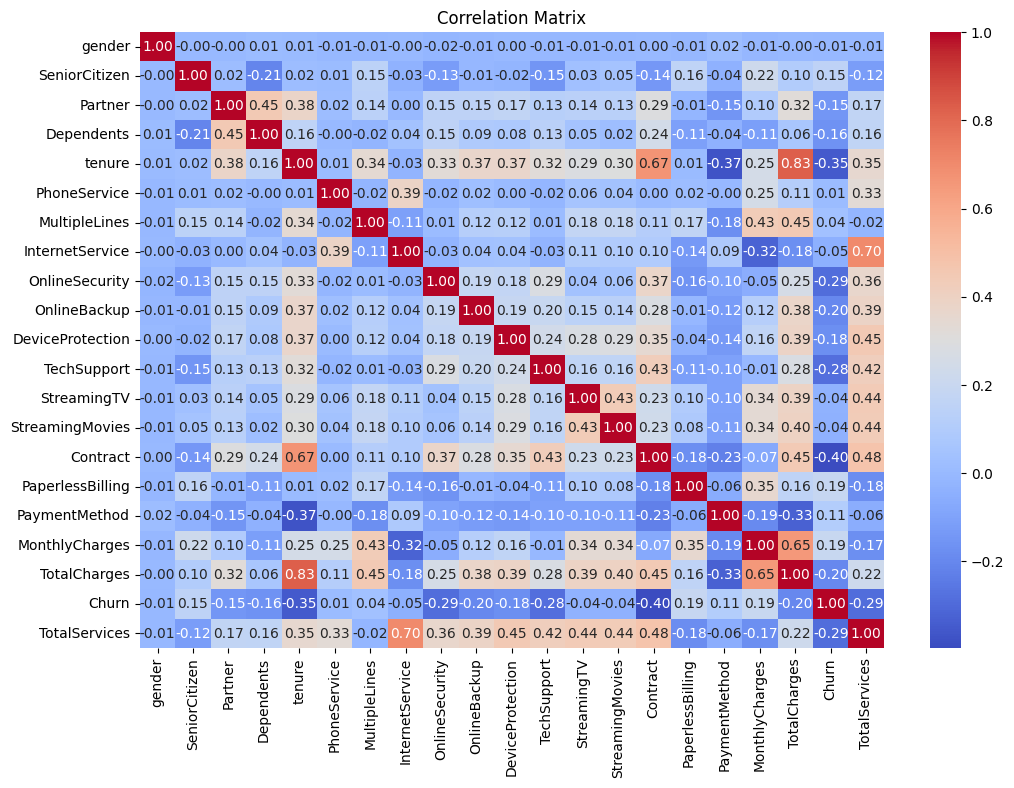

In [ ]:
# 4.4 Correlation Matrix
# Explanation: Visualize correlations, excluding non-numeric 'TenureGroup'.
plt.figure(figsize=(12, 8))
numeric_df = df.drop('TenureGroup', axis=1)
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.savefig(os.path.join(output_dir, 'correlation_matrix.png'))
plt.show()

In [ ]:
# --- Step 5: Predictive Modeling ---
# Explanation: Build machine learning models to predict churn, handling class imbalance with SMOTE.

# Prepare Data for Modeling
# Explanation: Split features and target, scale numerical features.
X = df.drop(['Churn', 'TenureGroup'], axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Save the scaler
joblib.dump(scaler, os.path.join(output_dir, 'scaler.pkl'))

['/content/drive/My Drive/Churn_Analysis_Outputs/scaler.pkl']

In [ ]:
# Handle Imbalanced Data with SMOTE
# Explanation: Balance the dataset to improve model performance on the minority class (churn).
print("\nChurn Distribution Before SMOTE:")
print(y_train.value_counts(normalize=True))
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("\nChurn Distribution After SMOTE:")
print(pd.Series(y_train_bal).value_counts(normalize=True))


Churn Distribution Before SMOTE:
Churn
0    0.734469
1    0.265531
Name: proportion, dtype: float64

Churn Distribution After SMOTE:
Churn
0    0.5
1    0.5
Name: proportion, dtype: float64



Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1036
           1       0.51      0.83      0.64       373

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409

ROC AUC: 0.8502864699245396


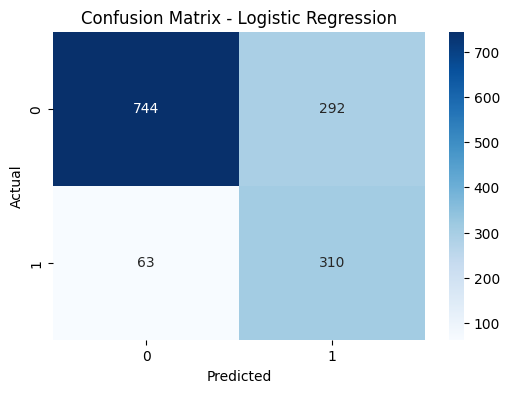


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1036
           1       0.55      0.65      0.60       373

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.77      0.77      1409

ROC AUC: 0.8295646278220004


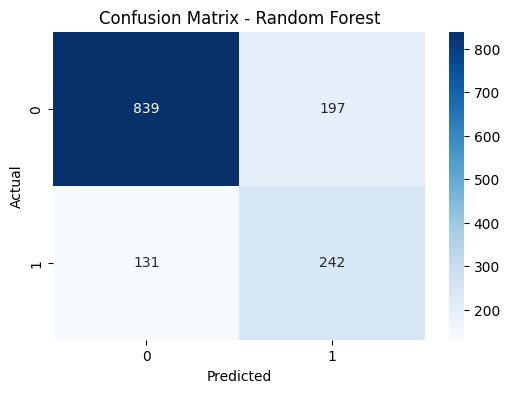


XGBoost Performance:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1036
           1       0.55      0.67      0.60       373

    accuracy                           0.77      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.77      0.77      1409

ROC AUC: 0.827907139234217


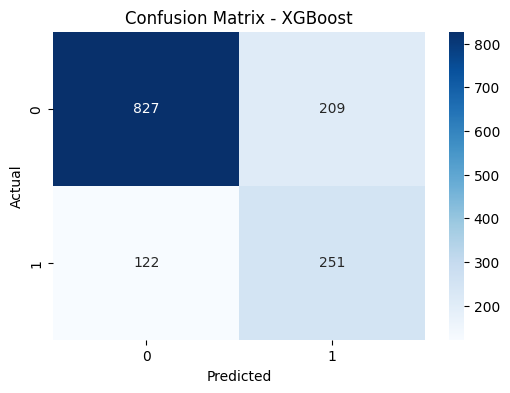

In [ ]:
# 5.3 Train and Evaluate Models
# Explanation: Train Logistic Regression, Random Forest, and XGBoost models.
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

for name, model in models.items():
    # Train the model
    model.fit(X_train_bal, y_train_bal)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate performance
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(os.path.join(output_dir, f'confusion_matrix_{name.lower().replace(" ", "_")}.png'))
    plt.show()

In [ ]:
# Feature Importance (Random Forest)
# Explanation: Extract and visualize feature importance from Random Forest.
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance (Random Forest):")
print(feature_importance)


Feature Importance (Random Forest):
             Feature  Importance
17    MonthlyCharges    0.155182
18      TotalCharges    0.148539
4             tenure    0.146867
14          Contract    0.125520
11       TechSupport    0.053727
8     OnlineSecurity    0.050943
16     PaymentMethod    0.047808
19     TotalServices    0.042567
3         Dependents    0.025205
0             gender    0.024604
9       OnlineBackup    0.023230
2            Partner    0.022907
7    InternetService    0.022095
15  PaperlessBilling    0.022037
6      MultipleLines    0.020289
10  DeviceProtection    0.018968
12       StreamingTV    0.015022
1      SeniorCitizen    0.014679
13   StreamingMovies    0.014202
5       PhoneService    0.005609


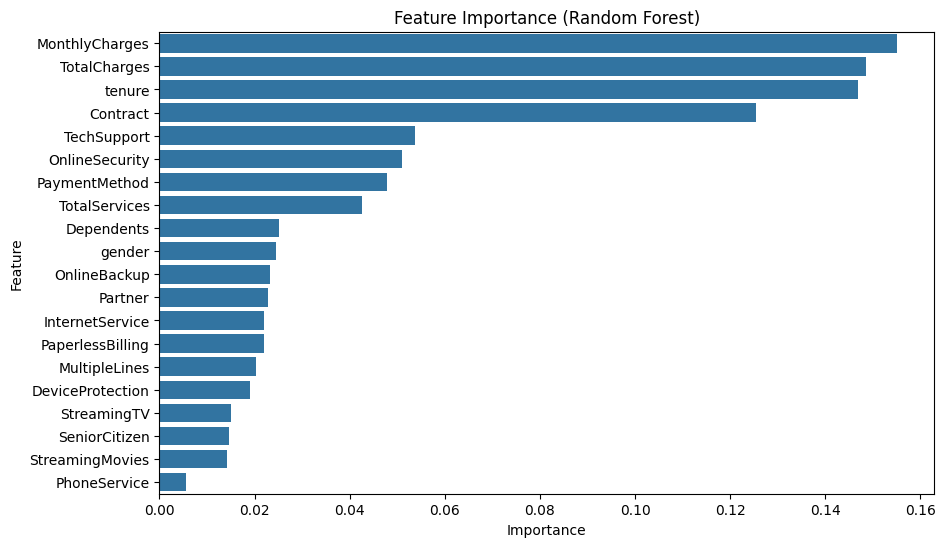

In [ ]:
# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (Random Forest)')
plt.savefig(os.path.join(output_dir, 'feature_importance.png'))
plt.show()

# Save feature importance to CSV
feature_importance.to_csv(os.path.join(output_dir, 'feature_importance.csv'), index=False)

In [ ]:
# Save the Best Model
# Explanation: Save the Random Forest model for future use.
joblib.dump(rf_model, os.path.join(output_dir, 'churn_model.pkl'))
print(f"\nRandom Forest model saved to '{os.path.join(output_dir, 'churn_model.pkl')}'")


Random Forest model saved to '/content/drive/My Drive/Churn_Analysis_Outputs/churn_model.pkl'


In [ ]:
# Prepare Data for Power BI
# Explanation: Save test predictions for Power BI visualization.
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
test_data = X_test.copy()
test_data['ActualChurn'] = y_test
test_data['PredictedChurn'] = y_pred_rf
test_data['ChurnProbability'] = y_pred_proba_rf
test_predictions_path = os.path.join(output_dir, 'test_predictions.csv')
test_data.to_csv(test_predictions_path, index=False)
print(f"\nTest predictions saved to '{test_predictions_path}'")


Test predictions saved to '/content/drive/My Drive/Churn_Analysis_Outputs/test_predictions.csv'


In [ ]:
# --- Step 7: Key Insights ---
# Explanation: Summarize findings to guide Power BI visualizations and recommendations.
print("\nKey Insights:")
print("- Customers with shorter tenure are more likely to churn.")
print("- Month-to-month contracts have higher churn rates than one- or two-year contracts.")
print("- Higher monthly charges and lack of services like OnlineSecurity/TechSupport may drive churn.")
print("- Feature importance suggests tenure, MonthlyCharges, and Contract are key predictors.")


Key Insights:
- Customers with shorter tenure are more likely to churn.
- Month-to-month contracts have higher churn rates than one- or two-year contracts.
- Higher monthly charges and lack of services like OnlineSecurity/TechSupport may drive churn.
- Feature importance suggests tenure, MonthlyCharges, and Contract are key predictors.


In [ ]:
# --- Step 8: Recommendations ---
print("\nRecommendations:")
print("- Offer discounts for longer-term contracts to reduce churn.")
print("- Bundle services like OnlineSecurity and TechSupport to improve retention.")
print("- Target high-risk customers (short tenure, high charges) with personalized offers.")


Recommendations:
- Offer discounts for longer-term contracts to reduce churn.
- Bundle services like OnlineSecurity and TechSupport to improve retention.
- Target high-risk customers (short tenure, high charges) with personalized offers.
